# Disaster tweets EDA

In [1]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

import nltk
from tqdm.notebook import tqdm

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [ ]:
!poetry add -D 'git+https://github.com/dnanhkhoa/nb_black.git@be0c810503867abc4a5e9d05ba75a16fce57dfee'
%load_ext lab_black

## Import dataset

In [3]:
dtypes = {
    "id": np.int16,
    "target": np.int8,
    "location": str,
    "keyword": str,
    "text": str,
}

df_train = pd.read_csv("./data/train.csv", dtype=dtypes)

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Missing values

- `location` has ~33% missing values.
- `keyword` has ~1% missing values.

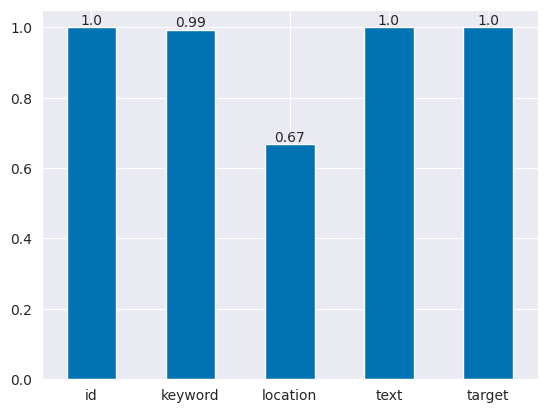

In [5]:
ax = (1 - df_train.isna().sum() / df_train.shape[0]).plot(kind="bar", rot=0)

plt.bar_label(
    container=ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
plt.show()

It doesn't look like missing value have a pattern in the dataset.

<Axes: >

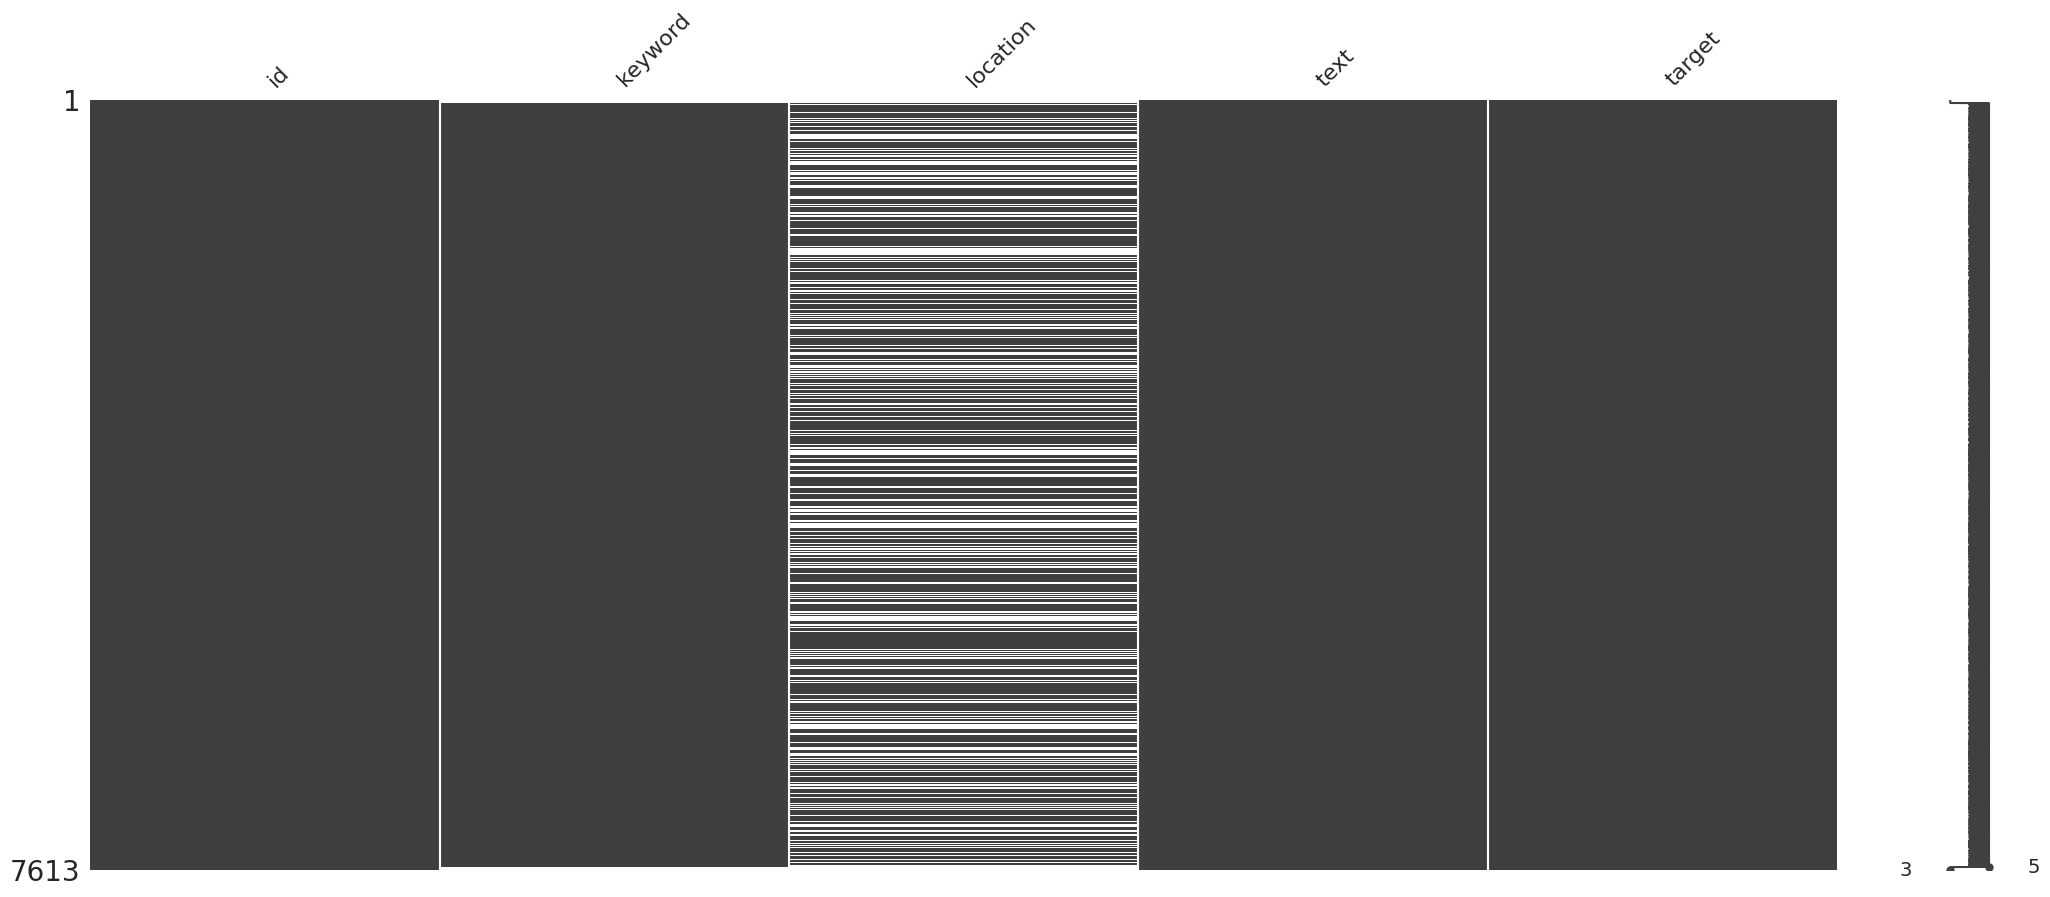

In [6]:
msno.matrix(df_train)

## Keywords

In [7]:
df_train["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
df_train["keyword"] = df_train["keyword"].str.replace("%20", "_")

## Target analysis

Target classes importance per keywords.  
The more a keyword value gets close to 1, the more it is associated to a real accident. 

In [9]:
keys_confidence = df_train.groupby("keyword")["target"].mean()

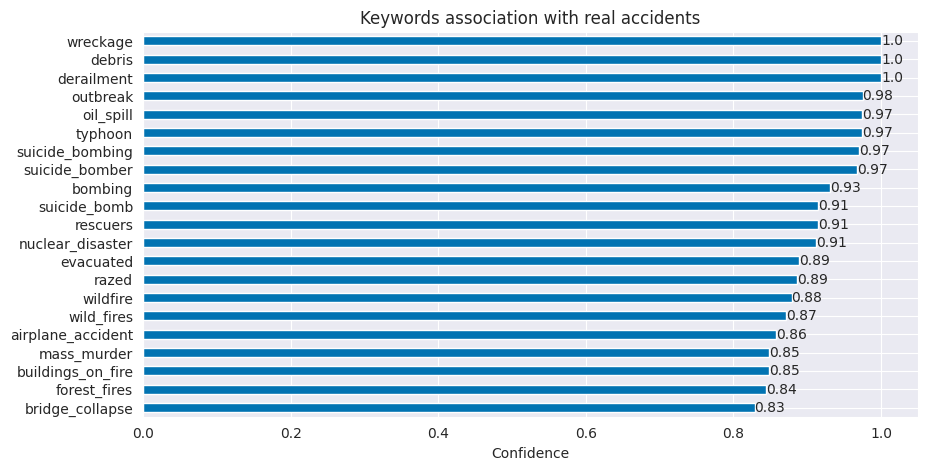

In [10]:
plt.figure(figsize=(10, 5))

ax = keys_confidence[keys_confidence > 0.8].sort_values().plot(kind="barh")

plt.title("Keywords association with real accidents")
plt.ylabel(None)
plt.xlabel("Confidence")
plt.bar_label(
    ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
plt.show()

In [11]:
df_train = df_train.merge(
    keys_confidence.reset_index().rename({"target": "keyword_confidence"}, axis=1),
    how="left",
    on="keyword",
)

In [12]:
df_train[~df_train["keyword"].isna()]

,id,keyword,location,text,target,keyword_confidence
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,0.361111
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,0.361111
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,0.361111
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,0.361111
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,0.361111
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,0.076923
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one,0,0.076923
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM,0,0.076923
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO,0,0.076923


## Feature engineering

### Extract hastag value if present in the tweet

In [13]:
def get_hastags(text_series: pd.Series) -> pd.Series:
    """Extract the hasgtag value in each text row."""
    hashtags = text_series.str.extract(r"(#[a-zA-Z]+)", expand=False)
    hashtags = hashtags.str.split("#", expand=True)[1]
    return hashtags


df_train["hashtag"] = get_hastags(df_train["text"])

In [14]:
df_train[~df_train["hashtag"].isna()].head()

,id,keyword,location,text,target,keyword_confidence,hashtag
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,NaN,earthquake
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,NaN,wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,NaN,Alaska
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,NaN,RockyFire
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,NaN,flood


Not that many tweets have a hashtag, it leaves us ~77% missing values for this column.

In [15]:
df_train["hashtag"].isna().sum() / df_train.shape[0]

0.7760409825298831

### Extract country and town (when applicable)

Some locations are formatted as "*city name*" + "," + "*US state or country*"

In [16]:
def split_locations(df: pd.DataFrame) -> pd.DataFrame:
    df_t = df.copy()
    locs_cond = df_t["location"].str.contains(r"^\w+,\s[A-Z]{2}", na=False)

    locs = df[locs_cond]["location"].str.strip()
    locs = locs.str.split(",", expand=True)

    df_t["city"] = locs[0].str.title()
    df_t["state"] = locs[1]

    return df_t

In [17]:
towns_states = df_train["location"].str.contains(r"^\w+,\s[A-Z]{2}", na=False)
df_locs = split_locations(df_train)

In [18]:
df_locs[~df_locs["city"].isna()].head()

,id,keyword,location,text,target,keyword_confidence,hashtag,city,state
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,0.361111,NaN,Philadelphia,PA
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,0.361111,NaN,London,UK
63,91,ablaze,"Concord, CA",@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680,1,0.361111,NaN,Concord,CA
64,92,ablaze,"Calgary, AB",#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc #EDM,0,0.361111,NowPlaying,Calgary,AB
68,97,accident,"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic moving 8m slower than usual. https://t.co/0GHk693EgJ,1,0.685714,NashvilleTraffic,Nashville,TN


## NLP on tweets text

### Basic analysis

In [19]:
example = df_train["text"][1]
tokens = nltk.word_tokenize(example)
tokens

['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', '.', 'Canada']

In [20]:
tagged = nltk.pos_tag(tokens)
tagged

[('Forest', 'NNP'),
 ('fire', 'NN'),
 ('near', 'IN'),
 ('La', 'NNP'),
 ('Ronge', 'NNP'),
 ('Sask', 'NNP'),
 ('.', '.'),
 ('Canada', 'NNP')]

In [21]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Forest/NNP)
  fire/NN
  near/IN
  (PERSON La/NNP Ronge/NNP Sask/NNP)
  ./.
  (PERSON Canada/NNP))


### VADER model

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [23]:
def get_vaders_scores(df: pd.DataFrame) -> pd.DataFrame:
    """Compute VADERS sentiment analysis polarity scores for each row."""
    df_vaders = df.copy()
    vaders = []

    for i, row in tqdm(df_vaders.iterrows(), total=len(df_vaders)):
        vader = sia.polarity_scores(row["text"])
        vader["id"] = row["id"]
        vaders.append(vader)

    return df_vaders.merge(pd.DataFrame.from_dict(vaders), how="left", on="id")

In [24]:
df_vaders = get_vaders_scores(df_train)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [25]:
df_vaders.head()

,id,keyword,location,text,target,keyword_confidence,hashtag,neg,neu,pos,compound
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,NaN,earthquake,0.000,0.851,0.149,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,NaN,0.286,0.714,0.000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,NaN,NaN,0.095,0.905,0.000,-0.2960
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,NaN,wildfires,0.000,1.000,0.000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,NaN,Alaska,0.000,1.000,0.000,0.0000


Sentiment scores show plausible results :
- real disasters mainly seen as negative
- false disasters mainly seen as postive
- a high neutrality score for each class

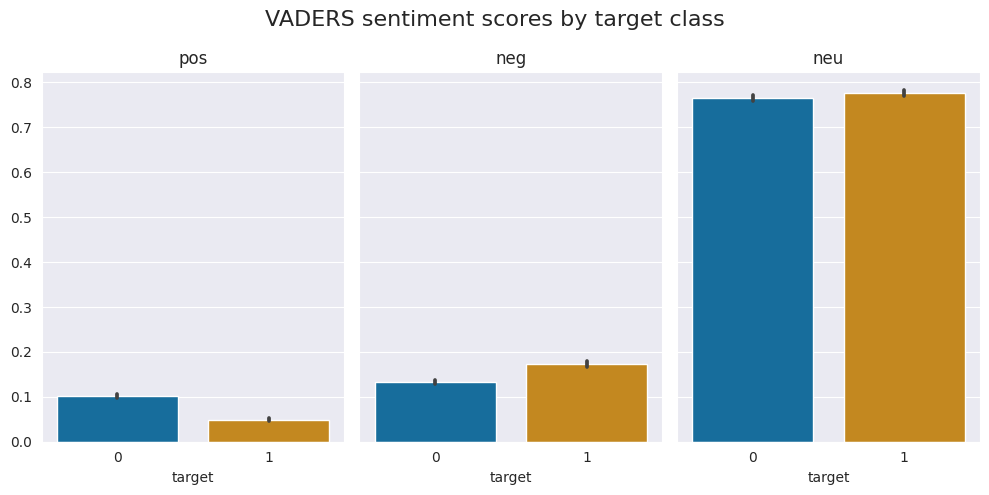

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle("VADERS sentiment scores by target class", fontsize=16)

for i, score in enumerate(["pos", "neg", "neu"]):
    sns.barplot(df_vaders, x="target", y=score, ax=axs[i])
    axs[i].set_title(score)
    axs[i].set_ylabel(None)

plt.tight_layout()
plt.show()

We would expect a low compound value for real accident, as it is supposed to represent negative event.  
It is pretty much the case in average.

However, VADER doesn't recognize language subtilities as irony.  
Plus certain real disaster tweets might use informal speech, which can be seen as neutral by the model.

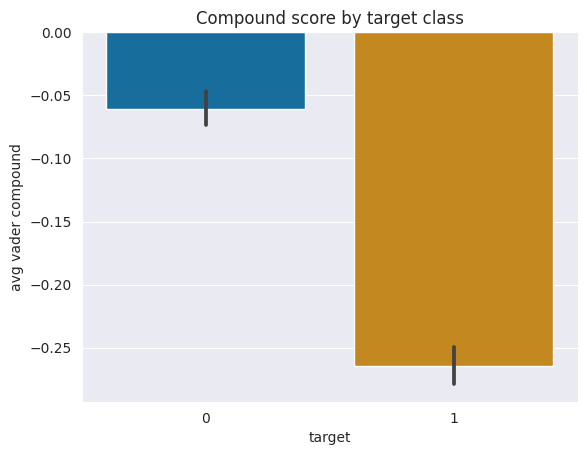

In [27]:
sns.barplot(df_vaders, x="target", y="compound")

plt.title("Compound score by target class")
plt.ylabel("avg vader compound")
plt.show()

### RoBERTa model